In [0]:
!pip install vaderSentiment

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-c8b8a54b-75ef-4014-83c7-820c59f6a494/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # for sentiment analysis

from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t

In [0]:
spark = SparkSession.builder.appName('BitcoinTweets').getOrCreate()
# Inizialize a spark session

In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv

dataset = pd.read_csv('/databricks/driver/bitcoin_tweets.csv', delimiter=",") 
# I import the dataframe that I will use for the analysis

df = spark.createDataFrame(dataset)
# Converting pandas df to Spark df

--2024-10-15 07:46:12--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.224.142, 16.12.18.6
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.224.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘bitcoin_tweets.csv.1’

bitcoin_tweets.csv. 100%[===================>]  23.56M  9.73MB/s    in 2.4s    

2024-10-15 07:46:15 (9.73 MB/s) - ‘bitcoin_tweets.csv.1’ saved [24708828/24708828]



In [0]:
df = df.write.saveAsTable('bitcoin_tweets_analysis')

In [0]:
# I eliminate null data and duplicates, and select the columns that I need for the analysis

df= df.dropDuplicates(subset=['timestamp','text'])
df = df.dropna(subset=['timestamp','text'])

df = df.select('id','timestamp','replies','likes','retweets','text')

%md
I defined a cleaning function (clean_tweet) that cleans the text:
- convert to lowercase and strip whitespace.
- removes mentions.
- removes hashtags.
- remove URLs.
- remove non-alphabetic characters.

In [0]:
def clean_tweet (tweet):
  
  tweet = tweet.lower().strip()
  tweet = re.sub(r'@\w+', '', tweet)
  tweet = re.sub(r'#\w+', '', tweet)
  tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
  tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

  return tweet.lower().strip()

In [0]:
# Used the UDF function to clean the tweets

clean_tweet_udf = f.udf(clean_tweet, t.StringType())
df = df.withColumn('cleaned_text', clean_tweet_udf(f.col('text'))) 

In [0]:
# remove rows where 'cleaned_text' is null and filter out rows where 'cleaned_text' is empty

df = df.dropna(subset=["cleaned_text"]).filter(f.col("cleaned_text") != "") 

In [0]:
# Extracted the date from the 'timestamp' column, created a new 'date' column and converted it to the date format.

df = df.withColumn('date', f.to_date(f.substring('timestamp',1,10), 'yyyy-MM-dd'))

SENTIMENT ANALYSIS

In [0]:
# Initialize SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

Calculate the compound score and classification of sentiment, if it is greater than 0 then it is positive, less than 0 it is negative, otherwise it is neutral

In [0]:
def sentiment_analysis(cleaned_text):

    scores = analyzer.polarity_scores(cleaned_text)
    compound_score = float(scores['compound'])

    if compound_score > 0:
        sentiment = 'positive'
    elif compound_score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    return sentiment

In [0]:
sentiment_analysis_udf = f.udf(sentiment_analysis,t.StringType())

In [0]:
df = df.withColumn('sentiment', sentiment_analysis_udf(f.col('cleaned_text')))

df = df.select('id','replies','likes','retweets','cleaned_text','date','sentiment')

In [0]:
df.show()

+--------------------+-------+-----+--------+--------------------+----------+---------+
|                  id|replies|likes|retweets|        cleaned_text|      date|sentiment|
+--------------------+-------+-----+--------+--------------------+----------+---------+
|1.132977654322388...|    0.0|  0.0|     0.0|current crypto pr...|2019-05-27|  neutral|
|1.132977797092269...|    0.0|  0.0|     0.0|angel crypto inve...|2019-05-27| positive|
|1.132979818688131...|    0.0|  0.0|     0.0|i liked what you ...|2019-05-27| positive|
|1.132979903740153...|    0.0|  0.0|     0.0|their vision is c...|2019-05-27| positive|
|1.132980442989236...|    0.0|  0.0|     0.0|advanced paper  p...|2019-05-27| positive|
|1.126278116467453...|    0.0|  0.0|     0.0|bitcoin btc curre...|2019-05-08|  neutral|
|1.126819183445139...|    0.0|  0.0|     0.0|bch is now worth ...|2019-05-10| positive|
|1.126715118853607...|    8.0| 89.0|    20.0|wait\nis bitcoin ...|2019-05-12| positive|
|1.126816166503120...|    0.0| 5

VISUALIZATION

Average likes by sentiment

In [0]:
likes_avg = df.groupBy("sentiment").agg(f.avg("likes").alias("avg_likes"))
likes_avg.show()

+---------+-----------------+
|sentiment|        avg_likes|
+---------+-----------------+
| positive| 9.25781940272133|
|  neutral|5.608501510309504|
| negative|11.66199919061109|
+---------+-----------------+



In [0]:
likes_data = likes_avg.toPandas()

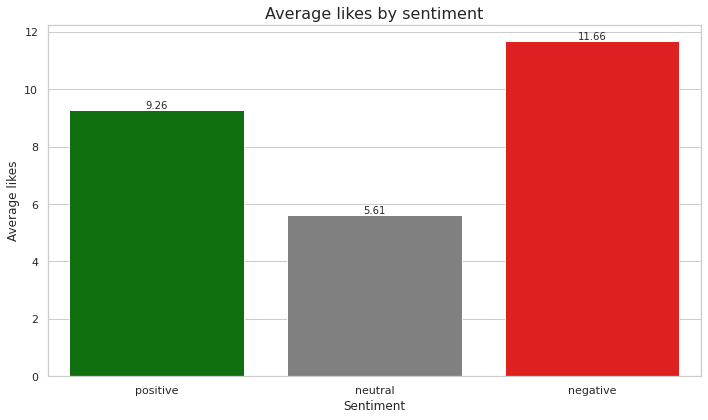

In [0]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=likes_data, x='sentiment', y='avg_likes', palette=['green', 'gray', 'red'])

plt.title('Average likes by sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Average likes', fontsize=12)

for index, value in enumerate(likes_data['avg_likes']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The average number of likes for tweets with positive sentiment is higher than that of tweets with neutral sentiment and slightly lower than that of tweets with negative sentiment, which have the highest average.

Average replies by sentiment

In [0]:
replies_avg = df.groupBy("sentiment").agg(f.avg("replies").alias("avg_replies"))
replies_avg.show()

+---------+------------------+
|sentiment|       avg_replies|
+---------+------------------+
| positive|1.3304765270660306|
|  neutral|0.4951845204220111|
| negative|1.2373128288142452|
+---------+------------------+



In [0]:
replies_data = replies_avg.toPandas()

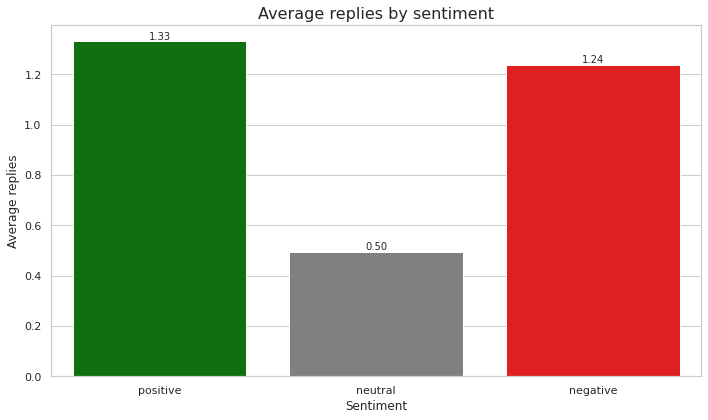

In [0]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=replies_data, x='sentiment', y='avg_replies', palette=['green', 'gray', 'red'])

plt.title('Average replies by sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Average replies', fontsize=12)

for index, value in enumerate(replies_data['avg_replies']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The average replies rate for tweets with positive sentiment is slightly higher than that for tweets with negative sentiment.

Tweet by sentiment

In [0]:
# Calculate the total tweets for each sentiment
total_tweets = df.count()
tweets_count = df.groupBy("sentiment").agg(f.count("*").alias("count"))

# Calculate the percentage of tweets for each sentiment
tweets_percentage = tweets_count.withColumn("percentage", f.col("count") / total_tweets * 100)

tweets_percentage.show()

+---------+-----+------------------+
|sentiment|count|        percentage|
+---------+-----+------------------+
| positive|33954|  36.9085276373716|
|  neutral|45686|  49.6613946410131|
| negative|12355|13.430077721615305|
+---------+-----+------------------+



In [0]:
tweets_percentage = tweets_percentage.toPandas()

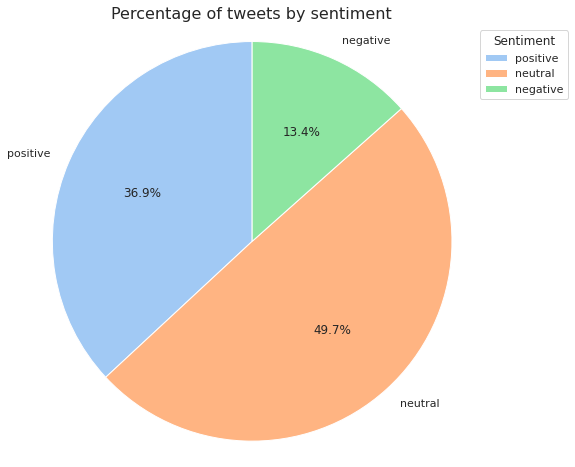

In [0]:
labels = tweets_percentage['sentiment'] 
sizes = tweets_percentage['percentage']  

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors = sns.color_palette("pastel")[0:3])
plt.legend(labels, title='Sentiment', loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Percentage of tweets by sentiment', fontsize=16)

plt.axis('equal')  
plt.show()

The percentage of tweets with neutral sentiment about Bitcoin is the highest, outpacing both positive and negative tweets.

Conclusion: Both in terms of likes and replies, the percentage of tweets with positive sentiment is higher than that of negative sentiments, even if the percentage of tweets with neutral sentiment is higher. This indicates that while many users express neutral opinions, those who show positive sentiment about Bitcoin are more numerous than those with negative sentiment.